In [2]:
import pandas as pd
import math
import numpy as np
import json

from pathlib import Path
import scipy.stats as st

In [3]:
# Collect predictions

def check_num_epochs(run):
    if Path(run / "val_log.csv").is_file():
        with open(run / 'config.json') as f:
            cfg = json.load(f)

        num_epochs = cfg['num_epochs']
        val_iter = cfg['validate_iter']
        num_epochs = int(num_epochs / val_iter)

        valid_log = pd.read_csv(run / "val_log.csv", header=None, index_col=0)
        if (len(valid_log.index)-1) < num_epochs:
            print("Wrong number of epochs in run: {}".format(run))
    else:
        print("val_log.csv not exists in run: {}".format(run))

def check_only_one_tensorboard(run):
    if len(list(Path(run / "runs").glob('*'))) > 1:
        print("More than 1 tensorboard folder in run: {}".format(run))

def collect_one(model_name, run, csv_file):
    check_num_epochs(run)
    check_only_one_tensorboard(run)
    
    with open(run / 'config.json') as f:
        cfg = json.load(f)

    run_number = cfg['seed']
    regime, inv_temp = float(run.parent.parts[-1].rsplit('-', 1)[1]), float(run.parent.parts[-2].rsplit('-', 1)[1])

    csv_path = run / csv_file
    if not csv_path.exists():
        print(f'Skipping not found: {csv_path}')
        return pd.DataFrame()
    
    data = pd.read_csv(csv_path)
    if data.empty:
        print(f'Pred file is empty: {csv_path}')

    data['model'] = model_name
    data['run_number'] = int(run_number)
    data['inv_temp'] = int(inv_temp)
    data['regime'] = int(regime)
    
    return data

def collect_all(model_name, root, csv_file, regimes=['1', '2', '5', '10', '20','100'], ignore_outliers=True):
    root = Path(root)

    metrics = []
    for inv_temp in list(root.glob("inv_temp-*")):
        for regime in list(inv_temp.glob("regime-*")):
            if regime.name.rsplit("-", 1)[1] in regimes:
                for run in list(regime.glob("run-*")):
                    if ignore_outliers and 'outlier' in run.as_posix():
                        continue
                    else:
                        metrics.append(collect_one(model_name, run, csv_file))
        
    metrics = pd.concat(metrics, ignore_index=True)
    
    return metrics

In [4]:
# Compute metrics for each detected run

def compute_metrics(data, grouping, metric_names=['Dice', 'Jaccard', 'Hausdorff Distance', 'Average Surface Distance']):
    metrics_dict_names = {
        'Dice': 'dice',
        'Jaccard': 'jaccard',
        'Hausdorff Distance': '95hd',
        'Average Surface Distance': 'asd'
    }

    columns = ['Model', '# Run', 'Inv Temp', 'Regime']
    columns.extend(metric_names)
    metrics = []
    
    data = data.copy().reset_index()
    grouped = data.groupby(grouping)
    
    for model_group, predictions in grouped:
        model_name, run_number, inv_temp, regime = model_group[0], int(model_group[1]), int(model_group[2]), int(model_group[3])
        
        metric_values = []
        for metric_name in metric_names:
            values = predictions['segm/{}'.format(metrics_dict_names[metric_name])].values
            mean_value = np.nanmean(values)
            if metric_name == 'Dice' or metric_name == 'Jaccard':
                metric_values.append((math.ceil(mean_value*10000)/10000)*100)
            else:
                if not np.isnan(mean_value):
                    metric_values.append(math.ceil(mean_value*100)/100)
                else:
                    metric_values.append(mean_value)
        
        metrics.append([model_name, run_number, inv_temp, regime, *metric_values])
        
    metrics_df = pd.DataFrame(metrics, columns=columns)
    
    return metrics_df

def summarize_metrics(metrics, metric_names=['Dice', 'Jaccard', 'Hausdorff Distance', 'Average Surface Distance'], confidence_level=0.90, return_ranges=False):

    def compute_ci(values, return_ranges=False):
        ci = st.t.interval(confidence_level, len(values)-1, loc=np.mean(values), scale=np.std(values)/(len(values)**0.5))

        if return_ranges:
            return ci
        else:
            return (ci[1]-ci[0]) / 2

    #mean_metrics = metrics.groupby(['Model', 'Inv Temp', 'Regime'])[metric_names].aggregate([('Mean', np.mean), ('STD', np.std), ("CI {}%".format(confidence_level), compute_ci)])
    mean_metrics = metrics.groupby(['Model', 'Inv Temp', 'Regime'])[metric_names].aggregate([('Mean', 'mean'), ("CI {}%".format(confidence_level), compute_ci)]) 

    return mean_metrics

<h1>PH2 Dataset</h1>

<h2>Evaluation - Data regime variations</h2>

In [360]:
EXP_ROOT = "/home/luca/datino/results/hebbian-bootstraping-semi-supervised-medical-imaging/runs"

REGIMES = ['1', '2', '5', '10', '20']
REGIMES = ['20']

runs = {
    #'UNet': list(Path(EXP_ROOT + '/PH2/semi_sup/').glob('kaiming_unet')),
    #'EM': list(Path(EXP_ROOT + '/PH2/semi_sup/').glob('em_unet')),
    #'UAMT': list(Path(EXP_ROOT + '/PH2/semi_sup/').glob('uamt_unet')),
    #'CPS': list(Path(EXP_ROOT + '/PH2/semi_sup/').glob('cps_unet')),
    'URPC': list(Path(EXP_ROOT + '/PH2/semi_sup/').glob('urpc_unet')),
    #'CCT': list(Path(EXP_ROOT + '/PH2/semi_sup/').glob('cct_unet')),
    #'VAE': list(Path(EXP_ROOT + '/PH2/semi_sup/').glob('unet_vae')),
    #'SuperPix': list(Path(EXP_ROOT + '/PH2/semi_sup/').glob('unet_superpix')),
}

In [361]:
# Collect predictions scanning runs
predictions = pd.concat([collect_all(k, r, 'test.csv', regimes=REGIMES, ignore_outliers=True) for k, v in runs.items() for r in v], ignore_index=True)

In [362]:
model_grouper = ['model', 'run_number', 'inv_temp', 'regime']
metrics = compute_metrics(predictions, model_grouper, metric_names=['Dice', 'Jaccard', 'Hausdorff Distance', 'Average Surface Distance'])

display(metrics)

summary = summarize_metrics(metrics, metric_names=['Dice', 'Jaccard', 'Hausdorff Distance', 'Average Surface Distance'], confidence_level=0.90)

display(summary)

,Model,# Run,Inv Temp,Regime,Dice,Jaccard,Hausdorff Distance,Average Surface Distance
0,URPC,2,1,20,91.91,85.02,6.32,2.46
1,URPC,4,1,20,91.55,84.41,6.38,2.51


Dice           Jaccard           Hausdorff Distance  \
                        Mean   CI 0.9%    Mean   CI 0.9%               Mean   
Model Inv Temp Regime                                                         
URPC  1        20      91.73  0.803609  84.715  1.361671               6.35   

                                Average Surface Distance            
                        CI 0.9%                     Mean   CI 0.9%  
Model Inv Temp Regime                                               
URPC  1        20      0.133935                    2.485  0.111612

<h2>Evaluation - Unsupervised Pretraining</h2>

In [372]:
EXP_ROOT = "/home/luca/datino/results/hebbian-bootstraping-semi-supervised-medical-imaging/runs"

REGIMES = ['100']

runs = {
    'H-UNet-SWTA-T': list(Path(EXP_ROOT + '/PH2/hebbian_unsup/').glob('unet_swta_t')),
    'H-UNet-URPC-SWTA-T': list(Path(EXP_ROOT + '/PH2/hebbian_unsup/').glob('unet_urpc_swta_t')),
    'H-UNet-CCT-SWTA-T': list(Path(EXP_ROOT + '/PH2/hebbian_unsup/').glob('unet_cct_swta_t')),
    'VAE-UNet': list(Path(EXP_ROOT + '/PH2/vae_unsup/').glob('unet_vae')),
    'Superpix-UNet': list(Path(EXP_ROOT + '/PH2/superpix_unsup/').glob('unet_superpix')),
}

In [373]:
# Collect predictions scanning runs
predictions = pd.concat([collect_all(k, r, 'test.csv', regimes=REGIMES, ignore_outliers=False) for k, v in runs.items() for r in v], ignore_index=True)

In [374]:
# Computing metrics
model_grouper = ['model', 'run_number', 'inv_temp', 'regime']
metrics = compute_metrics(predictions, model_grouper, metric_names=['Dice', 'Jaccard', 'Hausdorff Distance', 'Average Surface Distance'])

display(metrics)

summary = summarize_metrics(metrics, metric_names=['Dice', 'Jaccard', 'Hausdorff Distance', 'Average Surface Distance'], confidence_level=0.90)

display(summary)

,Model,# Run,Inv Temp,Regime,Dice,Jaccard,Hausdorff Distance,Average Surface Distance
0,H-UNet-CCT-SWTA-T,0,1,100,32.18,19.18,51.19,13.26
1,H-UNet-CCT-SWTA-T,0,5,100,29.59,17.37,51.49,13.52
2,H-UNet-CCT-SWTA-T,0,10,100,27.59,16.00,51.52,13.75
3,H-UNet-CCT-SWTA-T,0,20,100,30.90,18.28,51.17,13.20
4,H-UNet-CCT-SWTA-T,0,50,100,32.22,19.21,51.13,13.06
5,H-UNet-CCT-SWTA-T,0,75,100,32.44,19.36,51.12,13.05
6,H-UNet-CCT-SWTA-T,0,100,100,32.54,19.43,51.12,13.04
7,H-UNet-SWTA-T,0,1,100,30.01,17.65,51.33,13.60
8,H-UNet-SWTA-T,0,5,100,26.94,15.57,51.95,14.06
9,H-UNet-SWTA-T,0,10,100,25.57,14.66,51.84,14.04


/home/luca/anaconda3/envs/xnet/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2244: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/luca/anaconda3/envs/xnet/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2245: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Dice         Jaccard          \
                                     Mean CI 0.9%    Mean CI 0.9%   
Model              Inv Temp Regime                                  
H-UNet-CCT-SWTA-T  1        100     32.18     NaN   19.18     NaN   
                   5        100     29.59     NaN   17.37     NaN   
                   10       100     27.59     NaN   16.00     NaN   
                   20       100     30.90     NaN   18.28     NaN   
                   50       100     32.22     NaN   19.21     NaN   
                   75       100     32.44     NaN   19.36     NaN   
                   100      100     32.54     NaN   19.43     NaN   
H-UNet-SWTA-T      1        100     30.01     NaN   17.65     NaN   
                   5        100     26.94     NaN   15.57     NaN   
                   10       100     25.57     NaN   14.66     NaN   
                   20       100     31.88     NaN   18.96     NaN   
                   50       100     33.45     NaN   20.09     NaN   
                   75       100     33.85     NaN   20.37     NaN   
                   100      100     34.02     NaN   20.50     NaN   
                   200      100     32.35     NaN   19.30     NaN   
H-UNet-URPC-SWTA-T 1        100     35.48     NaN   21.57     NaN   
                   5        100     35.88     NaN   21.87     NaN   
                   10       100     35.21     NaN   21.37     NaN   
                   20       100     35.29     NaN   21.43     NaN   
                   50       100     35.08     NaN   21.27     NaN   
                   75       100     35.07     NaN   21.27     NaN   
                   100      100     35.06     NaN   21.26     NaN   
                   200      100     34.97     NaN   21.19     NaN   
Superpix-UNet      1        100     50.26     NaN   33.57     NaN   
VAE-UNet           1        100     75.57     NaN   60.74     NaN   

                                   Hausdorff Distance          \
                                                 Mean CI 0.9%   
Model              Inv Temp Regime                              
H-UNet-CCT-SWTA-T  1        100                 51.19     NaN   
                   5        100                 51.49     NaN   
                   10       100                 51.52     NaN   
                   20       100                 51.17     NaN   
                   50       100                 51.13     NaN   
                   75       100                 51.12     NaN   
                   100      100                 51.12     NaN   
H-UNet-SWTA-T      1        100                 51.33     NaN   
                   5        100                 51.95     NaN   
                   10       100                 51.84     NaN   
                   20       100                 51.83     NaN   
                   50       100                 51.70     NaN   
                   75       100                 51.65     NaN   
                   100      100                 51.62     NaN   
                   200      100                 51.15     NaN   
H-UNet-URPC-SWTA-T 1        100                 46.81     NaN   
                   5        100                 47.81     NaN   
                   10       100                 47.50     NaN   
                   20       100                 47.38     NaN   
                   50       100                 47.40     NaN   
                   75       100                 47.39     NaN   
                   100      100                 47.39     NaN   
                   200      100                 47.67     NaN   
Superpix-UNet      1        100                 48.07     NaN   
VAE-UNet           1        100                 38.65     NaN   

                                   Average Surface Distance          
                                                       Mean CI 0.9%  
Model              Inv Temp Regime                                   
H-UNet-CCT-SWTA-T  1        100                       13.26     NaN  
   

<h2>Evaluation - Hebbian Models Data Regime Variations</h2>

In [365]:
EXP_ROOT = "/home/luca/datino/results/hebbian-bootstraping-semi-supervised-medical-imaging/runs/"

REGIMES = ['1', '2', '5', '10', '20']
REGIMES = ['20']

runs = {
    'H-UNet-SWTA-T': list(Path(EXP_ROOT + '/PH2/semi_sup/').glob('h_unet_swta_t')),
    #'H-EM-SWTA-T': list(Path(EXP_ROOT + '/PH2/semi_sup/').glob('h_em_unet_swta_t')),
    #'H-UAMT-SWTA-T': list(Path(EXP_ROOT + '/PH2/semi_sup/').glob('h_uamt_unet_swta_t')),
    #'H-CPS-SWTA-T': list(Path(EXP_ROOT + '/PH2/semi_sup/').glob('h_cps_unet_swta_t')),
    #'H-URPC-SWTA-T': list(Path(EXP_ROOT + '/PH2/semi_sup/').glob('h_urpc_unet_swta_t')),
    #'H-CCT-SWTA-T': list(Path(EXP_ROOT + '/PH2/semi_sup/').glob('h_cct_unet_swta_t')),
}

In [370]:
# Collect predictions scanning runs
predictions = pd.concat([collect_all(k, r, 'test.csv', regimes=REGIMES, ignore_outliers=True) for k, v in runs.items() for r in v], ignore_index=True)

In [371]:
# Computing metrics
model_grouper = ['model', 'run_number', 'inv_temp', 'regime']
metrics = compute_metrics(predictions, model_grouper, metric_names=['Dice', 'Jaccard','Hausdorff Distance', 'Average Surface Distance'])

display(metrics)

summary = summarize_metrics(metrics, metric_names=['Dice', 'Jaccard', 'Hausdorff Distance', 'Average Surface Distance'], confidence_level=0.90)

display(summary)

,Model,# Run,Inv Temp,Regime,Dice,Jaccard,Hausdorff Distance,Average Surface Distance
0,H-UNet-SWTA-T,4,20,20,91.31,84.01,11.13,3.55
1,H-UNet-SWTA-T,7,20,20,91.68,84.63,7.49,2.71


Dice           Jaccard            \
                                 Mean   CI 0.9%    Mean   CI 0.9%   
Model         Inv Temp Regime                                       
H-UNet-SWTA-T 20       20      91.495  0.825932   84.32  1.383994   

                              Hausdorff Distance            \
                                            Mean   CI 0.9%   
Model         Inv Temp Regime                                
H-UNet-SWTA-T 20       20                   9.31  8.125384   

                              Average Surface Distance            
                                                  Mean   CI 0.9%  
Model         Inv Temp Regime                                     
H-UNet-SWTA-T 20       20                         3.13  1.875089

<h1>GlaS Dataset</h1>

<h2>Evaluation - Data regime variations</h2>

In [ ]:
EXP_ROOT = "/home/luca/datino/results/hebbian-bootstraping-semi-supervised-medical-imaging/runs"

REGIMES = ['1', '2', '5', '10', '20']

runs = {
    #'UNet': list(Path(EXP_ROOT + '/GlaS/semi_sup/').glob('kaiming_unet')),
    'EM': list(Path(EXP_ROOT + '/GlaS/semi_sup/').glob('em_unet')),
    'UAMT': list(Path(EXP_ROOT + '/GlaS/semi_sup/').glob('uamt_unet')),
    'CPS': list(Path(EXP_ROOT + '/GlaS/semi_sup/').glob('cps_unet')),
    'URPC': list(Path(EXP_ROOT + '/GlaS/semi_sup/').glob('urpc_unet')),
    'CCT': list(Path(EXP_ROOT + '/GlaS/semi_sup/').glob('cct_unet')),
    'VAE': list(Path(EXP_ROOT + '/GlaS/semi_sup/').glob('unet_vae')),
    'SuperPix': list(Path(EXP_ROOT + '/GlaS/semi_sup/').glob('unet_superpix')),
}

In [204]:
# Collect predictions scanning runs
predictions = pd.concat([collect_all(k, r, 'test.csv', regimes=REGIMES, ignore_outliers=True) for k, v in runs.items() for r in v], ignore_index=True)

In [205]:
model_grouper = ['model', 'run_number', 'inv_temp', 'regime']
metrics = compute_metrics(predictions, model_grouper, metric_names=['Dice', 'Jaccard', 'Hausdorff Distance', 'Average Surface Distance'])

display(metrics)

summary = summarize_metrics(metrics, metric_names=['Dice', 'Jaccard', 'Hausdorff Distance', 'Average Surface Distance'], confidence_level=0.90)

display(summary)

,Model,# Run,Inv Temp,Regime,Dice,Jaccard,Hausdorff Distance,Average Surface Distance
0,SuperPix,0,1,20,79.12,65.45,22.10,5.46
1,SuperPix,1,1,20,76.34,61.73,21.02,5.30
2,SuperPix,2,1,20,82.02,69.52,17.14,4.01
3,SuperPix,3,1,20,83.26,71.32,14.18,3.52
4,SuperPix,4,1,20,81.20,68.35,18.42,4.13
5,SuperPix,5,1,20,79.86,66.47,15.32,3.91
6,SuperPix,6,1,20,81.02,68.10,17.26,4.04
7,SuperPix,7,1,20,81.77,69.16,17.64,4.21
8,SuperPix,8,1,20,83.97,72.37,14.19,3.51
9,SuperPix,9,1,20,84.78,73.58,14.12,3.56


Dice           Jaccard            \
                            Mean   CI 0.9%    Mean   CI 0.9%   
Model    Inv Temp Regime                                       
SuperPix 1        20      81.334  1.363479  68.605  1.918563   

                         Hausdorff Distance            \
                                       Mean   CI 0.9%   
Model    Inv Temp Regime                                
SuperPix 1        20                 17.139  1.549557   

                         Average Surface Distance            
                                             Mean   CI 0.9%  
Model    Inv Temp Regime                                     
SuperPix 1        20                        4.165  0.379426

<h2>Evaluation - Unsupervised Pretraining</h2>

In [375]:
EXP_ROOT = "/home/luca/datino/results/hebbian-bootstraping-semi-supervised-medical-imaging/runs"

REGIMES = ['100']

runs = {
    'H-UNet-SWTA-T': list(Path(EXP_ROOT + '/GlaS/hebbian_unsup/').glob('unet_swta_t')),
    'H-UNet-URPC-SWTA-T': list(Path(EXP_ROOT + '/GlaS/hebbian_unsup/').glob('unet_urpc_swta_t')),
    'H-UNet-CCT-SWTA-T': list(Path(EXP_ROOT + '/GlaS/hebbian_unsup/').glob('unet_cct_swta_t')),
    'VAE-UNet': list(Path(EXP_ROOT + '/GlaS/vae_unsup/').glob('unet_vae')),
    'Superpix-UNet': list(Path(EXP_ROOT + '/GlaS/superpix_unsup/').glob('unet_superpix')),
}

In [376]:
# Collect predictions scanning runs
predictions = pd.concat([collect_all(k, r, 'test.csv', regimes=REGIMES, ignore_outliers=False) for k, v in runs.items() for r in v], ignore_index=True)

In [377]:
# Computing metrics
model_grouper = ['model', 'run_number', 'inv_temp', 'regime']
metrics = compute_metrics(predictions, model_grouper, metric_names=['Dice', 'Jaccard', 'Hausdorff Distance', 'Average Surface Distance'])

display(metrics)

summary = summarize_metrics(metrics, metric_names=['Dice', 'Jaccard', 'Hausdorff Distance', 'Average Surface Distance'], confidence_level=0.90)

display(summary)

/tmp/ipykernel_1197372/27984749.py:24: RuntimeWarning: Mean of empty slice
  mean_value = np.nanmean(values)


,Model,# Run,Inv Temp,Regime,Dice,Jaccard,Hausdorff Distance,Average Surface Distance
0,H-UNet-CCT-SWTA-T,0,1,100,38.71,24.00,NaN,NaN
1,H-UNet-CCT-SWTA-T,0,5,100,39.73,24.79,NaN,NaN
2,H-UNet-CCT-SWTA-T,0,10,100,40.49,25.38,NaN,NaN
3,H-UNet-CCT-SWTA-T,0,20,100,41.47,26.16,NaN,NaN
4,H-UNet-CCT-SWTA-T,0,50,100,41.68,26.33,NaN,NaN
5,H-UNet-CCT-SWTA-T,0,75,100,41.73,26.37,NaN,NaN
6,H-UNet-CCT-SWTA-T,0,100,100,41.75,26.38,NaN,NaN
7,H-UNet-SWTA-T,0,1,100,37.59,23.14,20.22,4.23
8,H-UNet-SWTA-T,0,5,100,38.85,24.11,20.49,4.26
9,H-UNet-SWTA-T,0,10,100,40.69,25.55,20.63,4.27


/home/luca/anaconda3/envs/xnet/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2244: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/luca/anaconda3/envs/xnet/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2245: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Dice         Jaccard          \
                                     Mean CI 0.9%    Mean CI 0.9%   
Model              Inv Temp Regime                                  
H-UNet-CCT-SWTA-T  1        100     38.71     NaN   24.00     NaN   
                   5        100     39.73     NaN   24.79     NaN   
                   10       100     40.49     NaN   25.38     NaN   
                   20       100     41.47     NaN   26.16     NaN   
                   50       100     41.68     NaN   26.33     NaN   
                   75       100     41.73     NaN   26.37     NaN   
                   100      100     41.75     NaN   26.38     NaN   
H-UNet-SWTA-T      1        100     37.59     NaN   23.14     NaN   
                   5        100     38.85     NaN   24.11     NaN   
                   10       100     40.69     NaN   25.55     NaN   
                   20       100     41.58     NaN   26.25     NaN   
                   50       100     41.81     NaN   26.43     NaN   
                   75       100     41.85     NaN   26.46     NaN   
                   100      100     41.87     NaN   26.48     NaN   
H-UNet-URPC-SWTA-T 1        100     61.08     NaN   43.97     NaN   
                   5        100     61.66     NaN   44.57     NaN   
                   10       100     61.22     NaN   44.12     NaN   
                   20       100     60.84     NaN   43.72     NaN   
                   50       100     60.74     NaN   43.61     NaN   
                   75       100     60.73     NaN   43.60     NaN   
                   100      100     60.72     NaN   43.60     NaN   
Superpix-UNet      1        100     60.22     NaN   43.08     NaN   
VAE-UNet           1        100     57.48     NaN   40.33     NaN   

                                   Hausdorff Distance          \
                                                 Mean CI 0.9%   
Model              Inv Temp Regime                              
H-UNet-CCT-SWTA-T  1        100                   NaN     NaN   
                   5        100                   NaN     NaN   
                   10       100                   NaN     NaN   
                   20       100                   NaN     NaN   
                   50       100                   NaN     NaN   
                   75       100                   NaN     NaN   
                   100      100                   NaN     NaN   
H-UNet-SWTA-T      1        100                 20.22     NaN   
                   5        100                 20.49     NaN   
                   10       100                 20.63     NaN   
                   20       100                 20.88     NaN   
                   50       100                 20.94     NaN   
                   75       100                 20.95     NaN   
                   100      100                 20.96     NaN   
H-UNet-URPC-SWTA-T 1        100                   NaN     NaN   
                   5        100                   NaN     NaN   
                   10       100                   NaN     NaN   
                   20       100                   NaN     NaN   
                   50       100                   NaN     NaN   
                   75       100                   NaN     NaN   
                   100      100                   NaN     NaN   
Superpix-UNet      1        100                 27.82     NaN   
VAE-UNet           1        100                 18.34     NaN   

                                   Average Surface Distance          
                                                       Mean CI 0.9%  
Model              Inv Temp Regime                                   
H-UNet-CCT-SWTA-T  1        100                         NaN     NaN  
                   5        100                         NaN     NaN  
                   10       100                         NaN     NaN  
                   20       100                         NaN     NaN  
                   50       100                         NaN  

<h2>Evaluation - Hebbian Models Data Regime Variations</h2>

In [34]:
EXP_ROOT = "/home/luca/datino/results/hebbian-bootstraping-semi-supervised-medical-imaging/runs/"

REGIMES = ['1', '2', '5', '10', '20']

runs = {
    'H-UNet-SWTA-T': list(Path(EXP_ROOT + '/GlaS/semi_sup/').glob('h_unet_swta_t')),
    #'H-EM-SWTA-T': list(Path(EXP_ROOT + '/GlaS/semi_sup/').glob('h_em_unet_swta_t')),
    #'H-UAMT-SWTA-T': list(Path(EXP_ROOT + '/GlaS/semi_sup/').glob('h_uamt_unet_swta_t')),
    #'H-CPS-SWTA-T': list(Path(EXP_ROOT + '/GlaS/semi_sup/').glob('h_cps_unet_swta_t')),
    #'H-URPC-SWTA-T': list(Path(EXP_ROOT + '/GlaS/semi_sup/').glob('h_urpc_unet_swta_t')),
    #'H-CCT-SWTA-T': list(Path(EXP_ROOT + '/GlaS/semi_sup/').glob('h_cct_unet_swta_t')),
}

In [35]:
# Collect predictions scanning runs
predictions = pd.concat([collect_all(k, r, 'test.csv', regimes=REGIMES, ignore_outliers=True) for k, v in runs.items() for r in v], ignore_index=True)

In [36]:
# Computing metrics
model_grouper = ['model', 'run_number', 'inv_temp', 'regime']
metrics = compute_metrics(predictions, model_grouper, metric_names=['Dice', 'Jaccard'])

display(metrics)

summary = summarize_metrics(metrics, metric_names=['Dice', 'Jaccard'])

display(summary)

,Model,# Run,Inv Temp,Regime,Dice,Jaccard
0,H-UNet-SWTA-T,0,1,1,68.93,52.58
1,H-UNet-SWTA-T,0,1,2,70.35,54.26
2,H-UNet-SWTA-T,0,1,5,76.85,62.41
3,H-UNet-SWTA-T,0,1,10,80.57,67.46
4,H-UNet-SWTA-T,0,1,20,82.61,70.37
...,...,...,...,...,...,...
345,H-UNet-SWTA-T,9,100,1,69.58,53.35
346,H-UNet-SWTA-T,9,100,2,67.77,51.25
347,H-UNet-SWTA-T,9,100,5,76.19,61.54
348,H-UNet-SWTA-T,9,100,10,78.59,64.73


Dice           Jaccard          
                                 Mean   CI 0.9%    Mean   CI 0.9%
Model         Inv Temp Regime                                    
H-UNet-SWTA-T 1        1       69.952  1.094228  53.820  1.311843
                       2       70.789  1.184045  54.825  1.424097
                       5       76.603  1.175030  62.121  1.538973
                       10      80.778  0.772999  67.772  1.089837
                       20      84.006  1.069091  72.462  1.595286
              5        1       69.682  1.058869  53.499  1.272498
                       2       70.797  1.218622  54.838  1.468635
                       5       76.677  1.027911  62.207  1.332258
                       10      80.289  0.695422  67.085  0.972014
                       20      83.806  0.686369  72.139  1.016079
              10       1       69.530  1.086753  53.325  1.315190
                       2       70.198  1.071394  54.109  1.282012
                       5       76.417  1.094484  61.871  1.439664
                       10      79.822  0.522838  66.428  0.722529
                       20      83.913  0.686701  72.302  1.010685
              20       1       69.080  0.962292  52.788  1.155739
                       2       71.085  1.235706  55.182  1.488131
                       5       77.186  1.050545  62.879  1.402849
                       10      79.668  1.005150  66.240  1.373727
                       20      83.398  0.586475  71.533  0.854042
              50       1       69.176  1.223345  52.917  1.490444
                       2       70.574  1.002400  54.556  1.199386
                       5       76.295  0.902477  61.699  1.178660
                       10      80.532  0.917135  67.437  1.285521
                       20      83.845  0.716868  72.202  1.062860
              75       1       69.465  1.220584  53.254  1.473262
                       2       71.181  1.280123  55.301  1.543957
                       5       76.485  1.109245  61.962  1.464490
                       10      80.509  0.923287  67.405  1.305779
                       20      84.154  0.506956  72.651  0.750021
              100      1       69.341  1.090493  53.103  1.318124
                       2       71.086  1.176088  55.180  1.410811
                       5       76.708  1.234731  62.264  1.634484
                       10      80.105  0.812047  66.835  1.129847
                       20      84.504  0.503263  73.174  0.756648

<h1>HMEPS Dataset</h1>

<h2>Evaluation - Data regime variations</h2>

In [71]:
EXP_ROOT = "/home/luca/datino/results/hebbian-bootstraping-semi-supervised-medical-imaging/runs"

REGIMES = ['1', '2', '5', '10', '20']

runs = {
    ##'UNet': list(Path(EXP_ROOT + '/HMEPS/semi_sup/').glob('kaiming_unet')),
    'EM': list(Path(EXP_ROOT + '/HMEPS/semi_sup/').glob('em_unet')),
    'UAMT': list(Path(EXP_ROOT + '/HMEPS/semi_sup/').glob('uamt_unet')),
    'CPS': list(Path(EXP_ROOT + '/HMEPS/semi_sup/').glob('cps_unet')),
    'URPC': list(Path(EXP_ROOT + '/HMEPS/semi_sup/').glob('urpc_unet')),
    'CCT': list(Path(EXP_ROOT + '/HMEPS/semi_sup/').glob('cct_unet')),
    'VAE': list(Path(EXP_ROOT + '/HMEPS/semi_sup/').glob('unet_vae')),
    'SuperPix': list(Path(EXP_ROOT + '/HMEPS/semi_sup/').glob('unet_superpix')),
}

In [74]:
# Collect predictions scanning runs
predictions = pd.concat([collect_all(k, r, 'test.csv', regimes=REGIMES, ignore_outliers=True) for k, v in runs.items() for r in v], ignore_index=True)

In [75]:
model_grouper = ['model', 'run_number', 'inv_temp', 'regime']
metrics = compute_metrics(predictions, model_grouper, metric_names=['Dice', 'Jaccard', 'Hausdorff Distance', 'Average Surface Distance'])

display(metrics)

summary = summarize_metrics(metrics, metric_names=['Dice', 'Jaccard', 'Hausdorff Distance', 'Average Surface Distance'], confidence_level=0.90)

display(summary)

,Model,# Run,Inv Temp,Regime,Dice,Jaccard,Hausdorff Distance,Average Surface Distance
0,EM,0,1,20,93.38,87.57,1.61,0.58
1,EM,3,1,20,94.08,88.82,1.24,0.49
2,EM,4,1,20,92.97,86.86,1.48,0.55
3,EM,5,1,20,91.38,84.13,2.85,0.91
4,EM,6,1,20,92.75,86.48,1.47,0.57
5,EM,8,1,20,93.73,88.19,1.47,0.48
6,EM,9,1,20,93.05,87.00,2.01,0.62


Dice              Jaccard            \
                            Mean   CI 0.9%       Mean   CI 0.9%   
Model Inv Temp Regime                                             
EM    1        20      93.048571  0.590016  87.007143  1.022973   

                      Hausdorff Distance           Average Surface Distance  \
                                    Mean   CI 0.9%                     Mean   
Model Inv Temp Regime                                                         
EM    1        20               1.732857  0.370875                      0.6   

                                
                       CI 0.9%  
Model Inv Temp Regime           
EM    1        20      0.09885

<h2>Evaluation - Unsupervised Pretraining</h2>

In [378]:
EXP_ROOT = "/home/luca/datino/results/hebbian-bootstraping-semi-supervised-medical-imaging/runs"

REGIMES = ['100']

runs = {
    'H-UNet-SWTA-T': list(Path(EXP_ROOT + '/HMEPS/hebbian_unsup/').glob('unet_swta_t')),
    'H-UNet-URPC-SWTA-T': list(Path(EXP_ROOT + '/HMEPS/hebbian_unsup/').glob('unet_urpc_swta_t')),
    'H-UNet-CCT-SWTA-T': list(Path(EXP_ROOT + '/HMEPS/hebbian_unsup/').glob('unet_cct_swta_t')),
    'VAE-UNet': list(Path(EXP_ROOT + '/HMEPS/vae_unsup/').glob('unet_vae')),
    'Superpix-UNet': list(Path(EXP_ROOT + '/HMEPS/superpix_unsup/').glob('unet_superpix')),
}

In [379]:
# Collect predictions scanning runs
predictions = pd.concat([collect_all(k, r, 'test.csv', regimes=REGIMES, ignore_outliers=False) for k, v in runs.items() for r in v], ignore_index=True)

In [380]:
# Computing metrics
model_grouper = ['model', 'run_number', 'inv_temp', 'regime']
metrics = compute_metrics(predictions, model_grouper, metric_names=['Dice', 'Jaccard', 'Hausdorff Distance', 'Average Surface Distance'])

display(metrics)

summary = summarize_metrics(metrics, metric_names=['Dice', 'Jaccard', 'Hausdorff Distance', 'Average Surface Distance'], confidence_level=0.90)

display(summary)

,Model,# Run,Inv Temp,Regime,Dice,Jaccard,Hausdorff Distance,Average Surface Distance
0,H-UNet-CCT-SWTA-T,0,1,100,2.08,1.05,89.42,23.74
1,H-UNet-CCT-SWTA-T,0,5,100,21.62,12.12,65.38,15.40
2,H-UNet-CCT-SWTA-T,0,10,100,64.93,48.07,51.63,9.98
3,H-UNet-CCT-SWTA-T,0,20,100,60.00,42.86,45.91,9.90
4,H-UNet-CCT-SWTA-T,0,50,100,71.20,55.28,42.84,7.95
5,H-UNet-CCT-SWTA-T,0,75,100,71.74,55.93,42.20,7.74
6,H-UNet-CCT-SWTA-T,0,100,100,72.29,56.60,41.93,7.52
7,H-UNet-SWTA-T,0,1,100,1.14,0.58,88.10,23.36
8,H-UNet-SWTA-T,0,5,100,75.32,60.41,35.89,6.31
9,H-UNet-SWTA-T,0,10,100,32.94,19.72,57.75,14.27


/home/luca/anaconda3/envs/xnet/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2244: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/luca/anaconda3/envs/xnet/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2245: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Dice         Jaccard          \
                                     Mean CI 0.9%    Mean CI 0.9%   
Model              Inv Temp Regime                                  
H-UNet-CCT-SWTA-T  1        100      2.08     NaN    1.05     NaN   
                   5        100     21.62     NaN   12.12     NaN   
                   10       100     64.93     NaN   48.07     NaN   
                   20       100     60.00     NaN   42.86     NaN   
                   50       100     71.20     NaN   55.28     NaN   
                   75       100     71.74     NaN   55.93     NaN   
                   100      100     72.29     NaN   56.60     NaN   
H-UNet-SWTA-T      1        100      1.14     NaN    0.58     NaN   
                   5        100     75.32     NaN   60.41     NaN   
                   10       100     32.94     NaN   19.72     NaN   
                   20       100     64.79     NaN   47.92     NaN   
                   50       100     70.21     NaN   54.09     NaN   
                   75       100     69.66     NaN   53.44     NaN   
                   100      100     68.65     NaN   52.26     NaN   
H-UNet-URPC-SWTA-T 1        100     52.87     NaN   35.94     NaN   
                   5        100     63.46     NaN   46.48     NaN   
                   10       100     62.89     NaN   45.87     NaN   
                   20       100     52.89     NaN   35.96     NaN   
                   50       100     59.47     NaN   42.32     NaN   
                   75       100     60.55     NaN   43.42     NaN   
                   100      100     61.00     NaN   43.89     NaN   
Superpix-UNet      1        100      0.00     NaN    0.00     NaN   
VAE-UNet           1        100      0.00     NaN    0.00     NaN   

                                   Hausdorff Distance          \
                                                 Mean CI 0.9%   
Model              Inv Temp Regime                              
H-UNet-CCT-SWTA-T  1        100                 89.42     NaN   
                   5        100                 65.38     NaN   
                   10       100                 51.63     NaN   
                   20       100                 45.91     NaN   
                   50       100                 42.84     NaN   
                   75       100                 42.20     NaN   
                   100      100                 41.93     NaN   
H-UNet-SWTA-T      1        100                 88.10     NaN   
                   5        100                 35.89     NaN   
                   10       100                 57.75     NaN   
                   20       100                 43.03     NaN   
                   50       100                 45.21     NaN   
                   75       100                 44.92     NaN   
                   100      100                 44.87     NaN   
H-UNet-URPC-SWTA-T 1        100                 45.98     NaN   
                   5        100                 31.29     NaN   
                   10       100                 28.73     NaN   
                   20       100                 29.61     NaN   
                   50       100                 31.20     NaN   
                   75       100                 32.29     NaN   
                   100      100                 32.46     NaN   
Superpix-UNet      1        100                 74.77     NaN   
VAE-UNet           1        100                  0.00     NaN   

                                   Average Surface Distance          
                                                       Mean CI 0.9%  
Model              Inv Temp Regime                                   
H-UNet-CCT-SWTA-T  1        100                       23.74     NaN  
                   5        100                       15.40     NaN  
                   10       100                        9.98     NaN  
                   20       100                        9.90     NaN  
                   50       100                        7.95  

<h2>Evaluation - Hebbian Models Data Regime Variations</h2>

In [119]:
EXP_ROOT = "/home/luca/datino/results/hebbian-bootstraping-semi-supervised-medical-imaging/runs/"

REGIMES = ['1', '2', '5', '10', '20']

runs = {
    'H-UNet-SWTA-T': list(Path(EXP_ROOT + '/HMEPS/semi_sup/').glob('h_unet_swta_t')),
    #'H-EM-SWTA-T': list(Path(EXP_ROOT + '/HMEPS/semi_sup/').glob('h_em_unet_swta_t')),
    #'H-UAMT-SWTA-T': list(Path(EXP_ROOT + '/HMEPS/semi_sup/').glob('h_uamt_unet_swta_t')),
    #'H-CPS-SWTA-T': list(Path(EXP_ROOT + '/HMEPS/semi_sup/').glob('h_cps_unet_swta_t')),
    #'H-URPC-SWTA-T': list(Path(EXP_ROOT + '/HMEPS/semi_sup/').glob('h_urpc_unet_swta_t')),
    #'H-CCT-SWTA-T': list(Path(EXP_ROOT + '/HMEPS/semi_sup/').glob('h_cct_unet_swta_t')),
}

In [120]:
# Collect predictions scanning runs
predictions = pd.concat([collect_all(k, r, 'test.csv', regimes=REGIMES, ignore_outliers=True) for k, v in runs.items() for r in v], ignore_index=True)

In [121]:
# Computing metrics
model_grouper = ['model', 'run_number', 'inv_temp', 'regime']
metrics = compute_metrics(predictions, model_grouper, metric_names=['Dice', 'Jaccard'])

display(metrics)

summary = summarize_metrics(metrics, metric_names=['Dice', 'Jaccard'])

display(summary)

,Model,# Run,Inv Temp,Regime,Dice,Jaccard
0,H-UNet-SWTA-T,0,1,1,88.98,80.14
1,H-UNet-SWTA-T,0,1,2,78.67,64.84
2,H-UNet-SWTA-T,0,1,5,91.87,84.95
3,H-UNet-SWTA-T,0,1,10,92.33,85.75
4,H-UNet-SWTA-T,0,1,20,93.31,87.46
...,...,...,...,...,...,...
245,H-UNet-SWTA-T,9,75,1,89.30,80.67
246,H-UNet-SWTA-T,9,75,2,92.16,85.45
247,H-UNet-SWTA-T,9,75,5,89.67,81.28
248,H-UNet-SWTA-T,9,75,10,93.34,87.51


Dice            Jaccard           
                                 Mean    CI 0.9%    Mean    CI 0.9%
Model         Inv Temp Regime                                      
H-UNet-SWTA-T 1        1       86.833   2.565174  76.981   3.800297
                       2       83.071   7.928661  72.996   9.731711
                       5       91.833   0.795161  84.924   1.353546
                       10      92.358   0.807730  85.827   1.372531
                       20      93.104   0.388094  87.101   0.671492
              5        1       81.263  14.732730  73.522  13.791181
                       2       83.204  15.080716  76.746  14.342463
                       5       91.589   1.883585  84.639   3.075142
                       10      90.703   2.721856  83.302   4.282226
                       20      92.841   0.858697  86.672   1.470963
              20       1       81.873  14.820850  74.494  13.898426
                       2       90.814   1.499998  83.268   2.387843
                       5       92.868   0.669414  86.698   1.149903
                       10      93.107   0.606680  87.116   1.042628
                       20      93.622   0.223441  88.003   0.393467
              50       1       87.171   4.515788  77.974   6.030091
                       2       85.357  11.059304  77.871  11.914440
                       5       92.743   0.731157  86.493   1.255277
                       10      92.067   0.985659  85.342   1.689766
                       20      93.419   0.236513  87.649   0.417817
              75       1       79.016  14.976125  70.600  14.479520
                       2       90.275   2.905126  82.611   4.314464
                       5       86.225  10.025526  78.746  11.314725
                       10      92.852   0.721109  86.678   1.240284
                       20      93.381   0.347349  87.588   0.607786

<h1>Plots</h1>

In [163]:
import matplotlib.pyplot as plt

<h3>GlaS Dataset</h3>

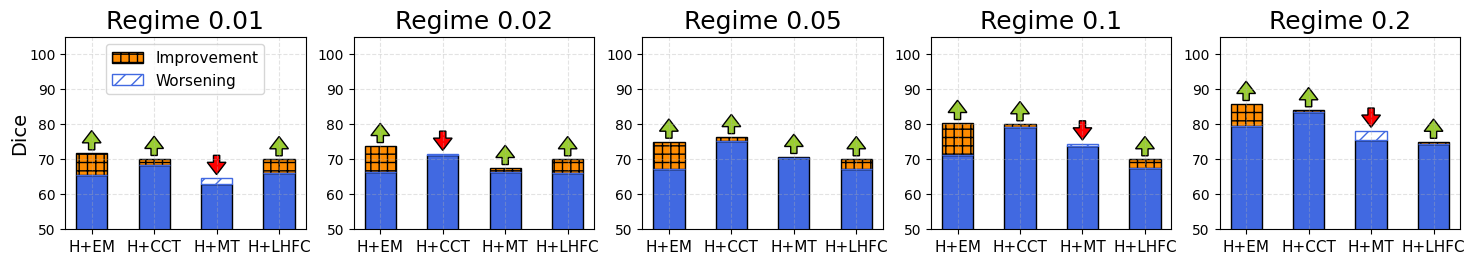

In [165]:
width=0.5

x_labels = ['H+EM', 'H+CCT', 'H+UAMT', 'H+CPS', 'H+URPC']
regimes = ['0.01', '0.02', '0.05', '0.1', '0.2']

fig, axes = plt.subplots(1, 5, figsize=(18, 2.5), squeeze=False)

for j in range(5):
    #axes[0][j].xaxis.set_major_locator(ticker.NullLocator())
    #axes[0][j].set_xlabel("Method", fontsize=10)
    axes[0][j].tick_params(axis='x', labelrotation=0)
    axes[0][j].xaxis.set_tick_params(labelsize=11)
    axes[0][j].grid(linestyle='--', linewidth=0.8, alpha=0.35)
    #axes[0][j].set_ylabel("Dice", fontsize=14, labelpad=-5)
    axes[0][j].yaxis.set_tick_params(labelsize=10)
    axes[0][j].set_title('Regime {}'.format(regimes[j]), fontsize=18)
    axes[0][j].set_ylim([50, 105])

axes[0][0].set_ylabel("Dice", fontsize=14, labelpad=0)


############################
# Regime 0.01
values_001 = [65.58, 68.45, 64.63-(64.63-62.85), 65.96]
improvements_001 = [(71.70-65.58), (70.09-68.45), 0, (70-65.96)]
worsening_001 = [0, 0, (64.63-62.85), 0]

axes[0,0].bar(x_labels, values_001, width=width, edgecolor="black", color='royalblue')
axes[0,0].bar(x_labels, improvements_001, bottom=values_001, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[0,0].bar(x_labels, worsening_001, bottom=values_001, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[0,0].arrow(x=0, y=71.70+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,0].arrow(x=1, y=70.09+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,0].arrow(x=2, y=64.63+1+2+3.5, dx=0, dy=-2, width=.1, facecolor='red', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,0].arrow(x=3, y=70+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,0].legend(ncol=1, fontsize=11, loc='upper center')

############################
# Regime 0.02
values_002 = [66.42, 71.54-(71.54-71.19), 66.46, 66.00]
improvements_002 = [(73.78-66.42), 0, (67.50-66.46), (70-66.00)]
worsening_002 = [0, (71.54-71.19), 0, 0]

axes[0,1].bar(x_labels, values_002, width=width, edgecolor="black", color='royalblue')
axes[0,1].bar(x_labels, improvements_002, bottom=values_002, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[0,1].bar(x_labels, worsening_002, bottom=values_002, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[0,1].arrow(x=0, y=73.78+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,1].arrow(x=1, y=71.54+1+2+3.5, dx=0, dy=-2, width=.1, facecolor='red', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,1].arrow(x=2, y=67.50+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,1].arrow(x=3, y=70+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
#axes[1,0].legend(ncol=2, fontsize=12, loc='lower center')

############################
# Regime 0.05
values_005 = [67.14, 75.35, 70.31, 67.36]
improvements_005 = [(75.02-67.14), (76.33-75.35), (70.66-70.31), (70-67.36)]
worsening_005 = [0, 0, 0, 0]

axes[0,2].bar(x_labels, values_005, width=width, edgecolor="black", color='royalblue')
axes[0,2].bar(x_labels, improvements_005, bottom=values_005, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[0,2].bar(x_labels, worsening_005, bottom=values_005, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[0,2].arrow(x=0, y=75.02+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,2].arrow(x=1, y=76.33+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,2].arrow(x=2, y=70.66+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,2].arrow(x=3, y=70+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
#axes[0,2].legend(ncol=2, fontsize=12, loc='lower center')

############################
# Regime 0.1
values_01 = [71.29, 79.34, 74.49-(74.49-73.86), 67.63]
improvements_01 = [(80.36-71.29), (80-79.34), 0, (70-67.63)]
worsening_01 = [0, 0, (74.49-73.86), 0]

axes[0,3].bar(x_labels, values_01, width=width, edgecolor="black", color='royalblue')
axes[0,3].bar(x_labels, improvements_01, bottom=values_01, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[0,3].bar(x_labels, worsening_01, bottom=values_01, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[0,3].arrow(x=0, y=80.36+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,3].arrow(x=1, y=80+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,3].arrow(x=2, y=74.49+1+2+3.5, dx=0, dy=-2, width=.1, facecolor='red', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,3].arrow(x=3, y=70+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
#axes[3,0].legend(ncol=2, fontsize=12, loc='lower center')

############################
# Regime 0.2
values_02 = [79.61, 83.60, 78.14-(78.14-75.58), 74.25]
improvements_02 = [(85.80-79.61), (84-83.60), 0, (75-74.25)]
worsening_02 = [0, 0, (78.14-75.58), 0]

axes[0,4].bar(x_labels, values_02, width=width, edgecolor="black", color='royalblue')
axes[0,4].bar(x_labels, improvements_02, bottom=values_02, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[0,4].bar(x_labels, worsening_02, bottom=values_02, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[0,4].arrow(x=0, y=85.80+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,4].arrow(x=1, y=84+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,4].arrow(x=2, y=78.14+1+2+3.5, dx=0, dy=-2, width=.1, facecolor='red', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,4].arrow(x=3, y=75+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
#axes[4,0].legend(ncol=2, fontsize=12, loc='lower center')


#plt.tight_layout()
plt.subplots_adjust(wspace=.2, hspace=.1)
plt.savefig("./figures/glas_plots_h.pdf", format="pdf", bbox_inches="tight")
plt.show()